<a href="https://colab.research.google.com/github/romanzes637/plate-heat-exchanger/blob/main/plate_heat_exchanger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

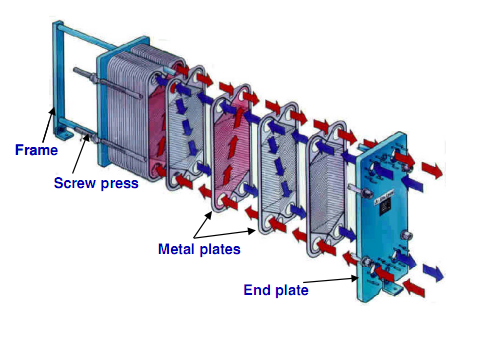

# Plate heat exchanger
## Stages of calcualtion
1. Physical properties of fluids $\rho,\nu,\mu,k, c_p, ... TODO = F(P, T)$
2. Geometric charactersistics of channels $d_e=4A/P$
3. Heat balance $G_h  c_{ph} dt_h = G_c c_{pc} dt_c$ and/or сontinuity equation $G=\rho v A$
4. Reynolds number $Re=\rho v d_e/\mu=v d_e/\nu$
5. Prandtl number $Pr=c_p\mu/k$
6. Nusselt number $Nu=h d_e/k=F(Re, ...)$
7. Temperature difference $dt=dt_{log}=(dt_h-dt_c)/(ln(dt_h)-ln(dt_c))$
8. Heat transfer equation $A=Q/(h \cdot dt)$, there $h=1/(1/h_h+t_p/k_p+1/h_c)$
9. Heat exchanger sizes
10. Euler number and pressure drop $Eu=\Delta P/\rho v^2=F(Re, ...)$


## Input parameters
| Parameter | Description | Dimension |
|:-:|:-:|:-:|  
| $g_h$    | Heating (hot) fluid mass flow rate    | $kg/s$ |
| $g_c$    | Heated (cold) fluid mass flow rate    | $kg/s$ |
| $t1_h$   | Inlet temperature of hot fluid        | $K$    |
| $t1_c$   | Inlet temperature of cold fluid       | $K$    |
| $p1_h$   | Inlet pressure of hot fluid           | $Pa$   |
| $p1_c$   | Inlet pressure of cold fluid          | $Pa$   |
| $t2_h$   | Outler temperature of hot fluid       | $K$    |
| $t2_c$   | Outler temperature of cold fluid      | $K$    |
| $p2_h$   | Outler pressure of hot fluid          | $Pa$   |
| $p2_c$   | Outler pressure of cold fluid         | $Pa$   |
| $v_h$    | Velocity of hot fluid                 | $m/s$  |
| $v_c$    | Velocity of cold fluid                | $m/s$  |
| $h$      | Height of heat exchanger              | $m$    |
| $l$      | Length of heat exchanger              | $m$    |
| $w$      | Width (depth) of heat exchanger       | $m$    |
| $mat_h$  | Hot fluid ("water", "air")            | -      |
| $mat_c$  | Cold fluid ("water", "air")           | -      |
| $mat_p$  | Material of plates ("steel")          | -      |
| $plate$  | Plate object (see Surfaces)           | -      |
| $nure_h$ | Nu(Re,...) correlation for hot fluid  | -      |
| $nure_c$ | Nu(Re,...) correlation for cold fluid | -      |
| $eure_h$ | Eu(Re) correlation for hot fluid      | -      |
| $eure_c$ | Eu(Re) orrelation for cold fluid      | -      |

## References

[Lavrov 1999](https://drive.google.com/file/d/1js-y_GA4I-jKWQBwpS4TDCQFKMTHu8Eq/view?usp=sharing)

[APV handbook](https://water-cti.com/pdf/ESPG/HX3-APV-SPX_Heat_Transfer_Handbook_2008.pdf)

[PLATE AND FRAME HEAT EXCHANGERS](http://thermopedia.com/content/1035/)


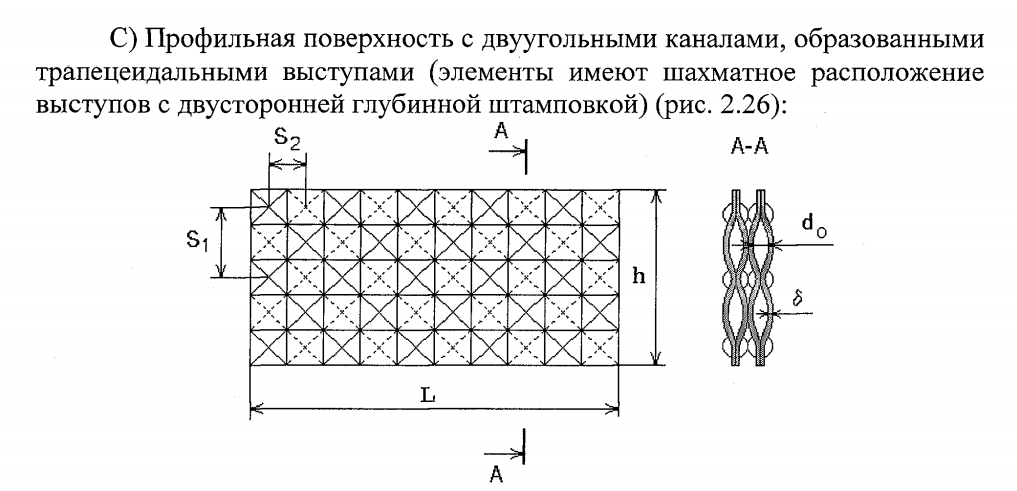

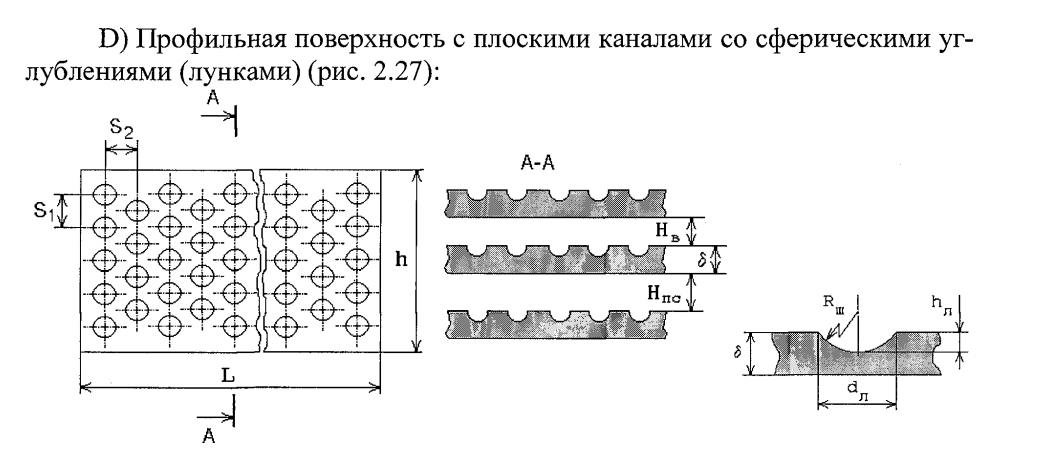

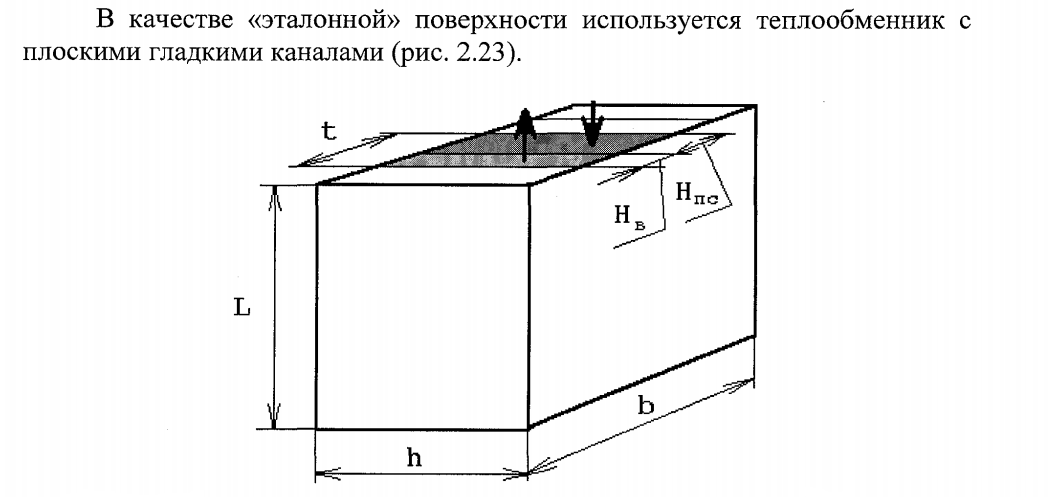

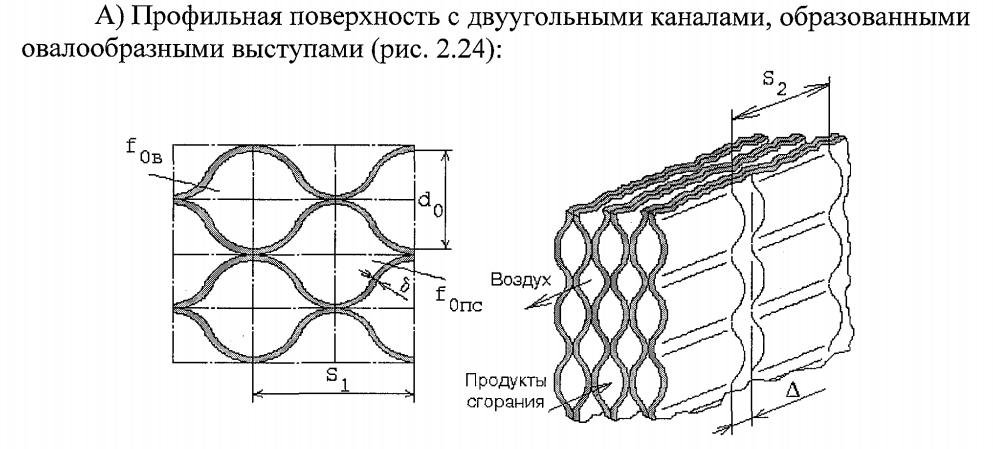

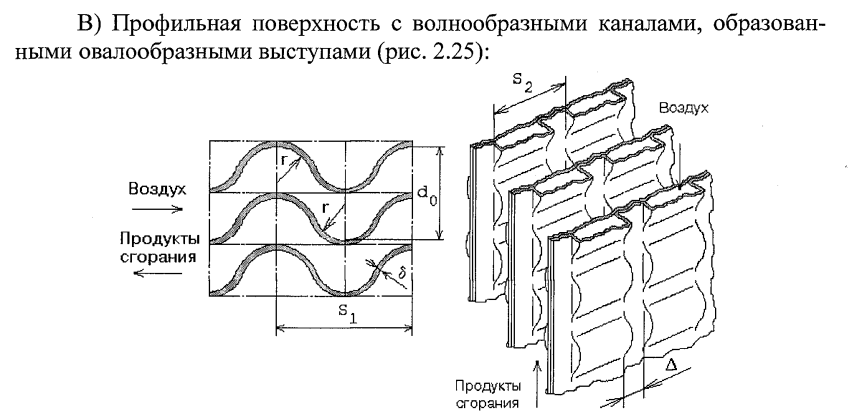

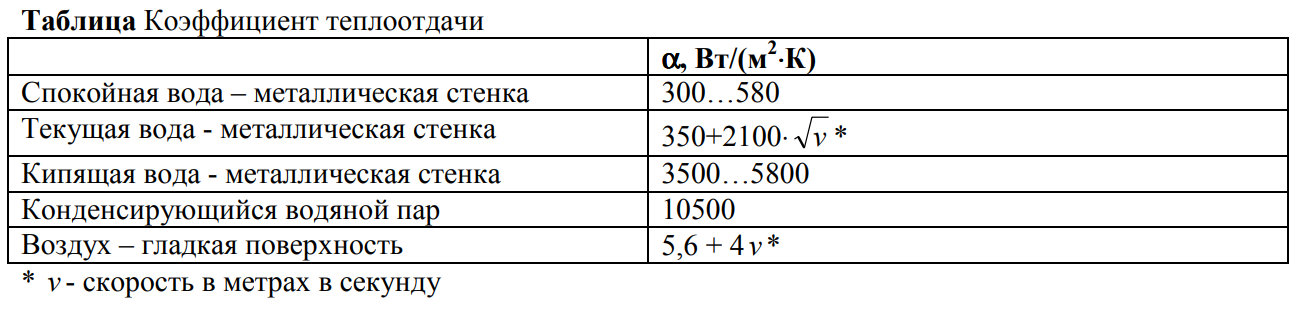

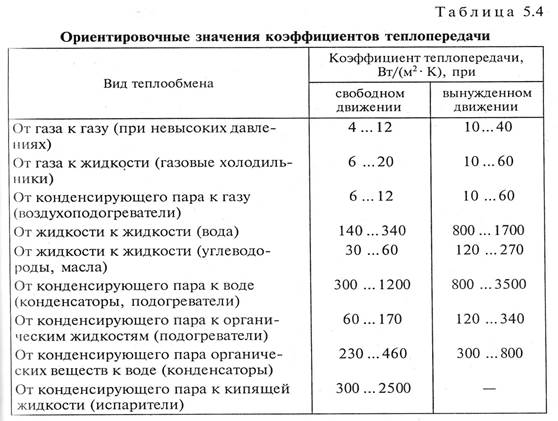

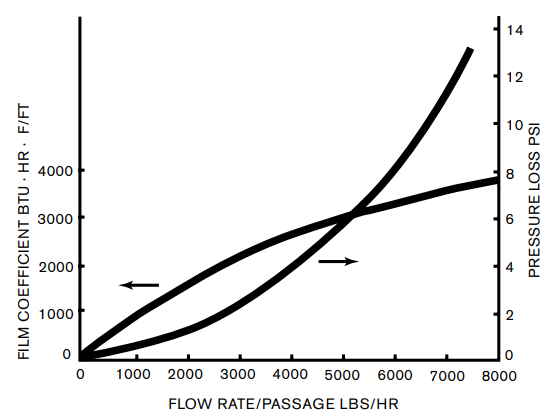

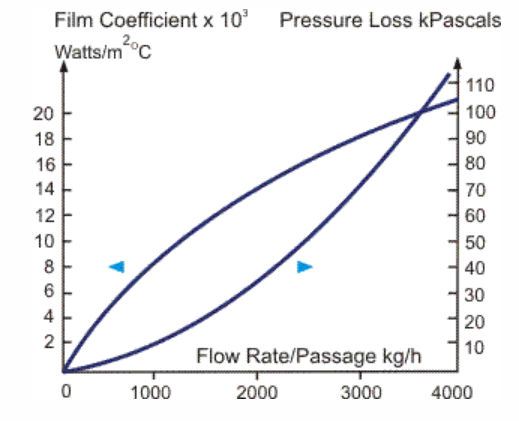

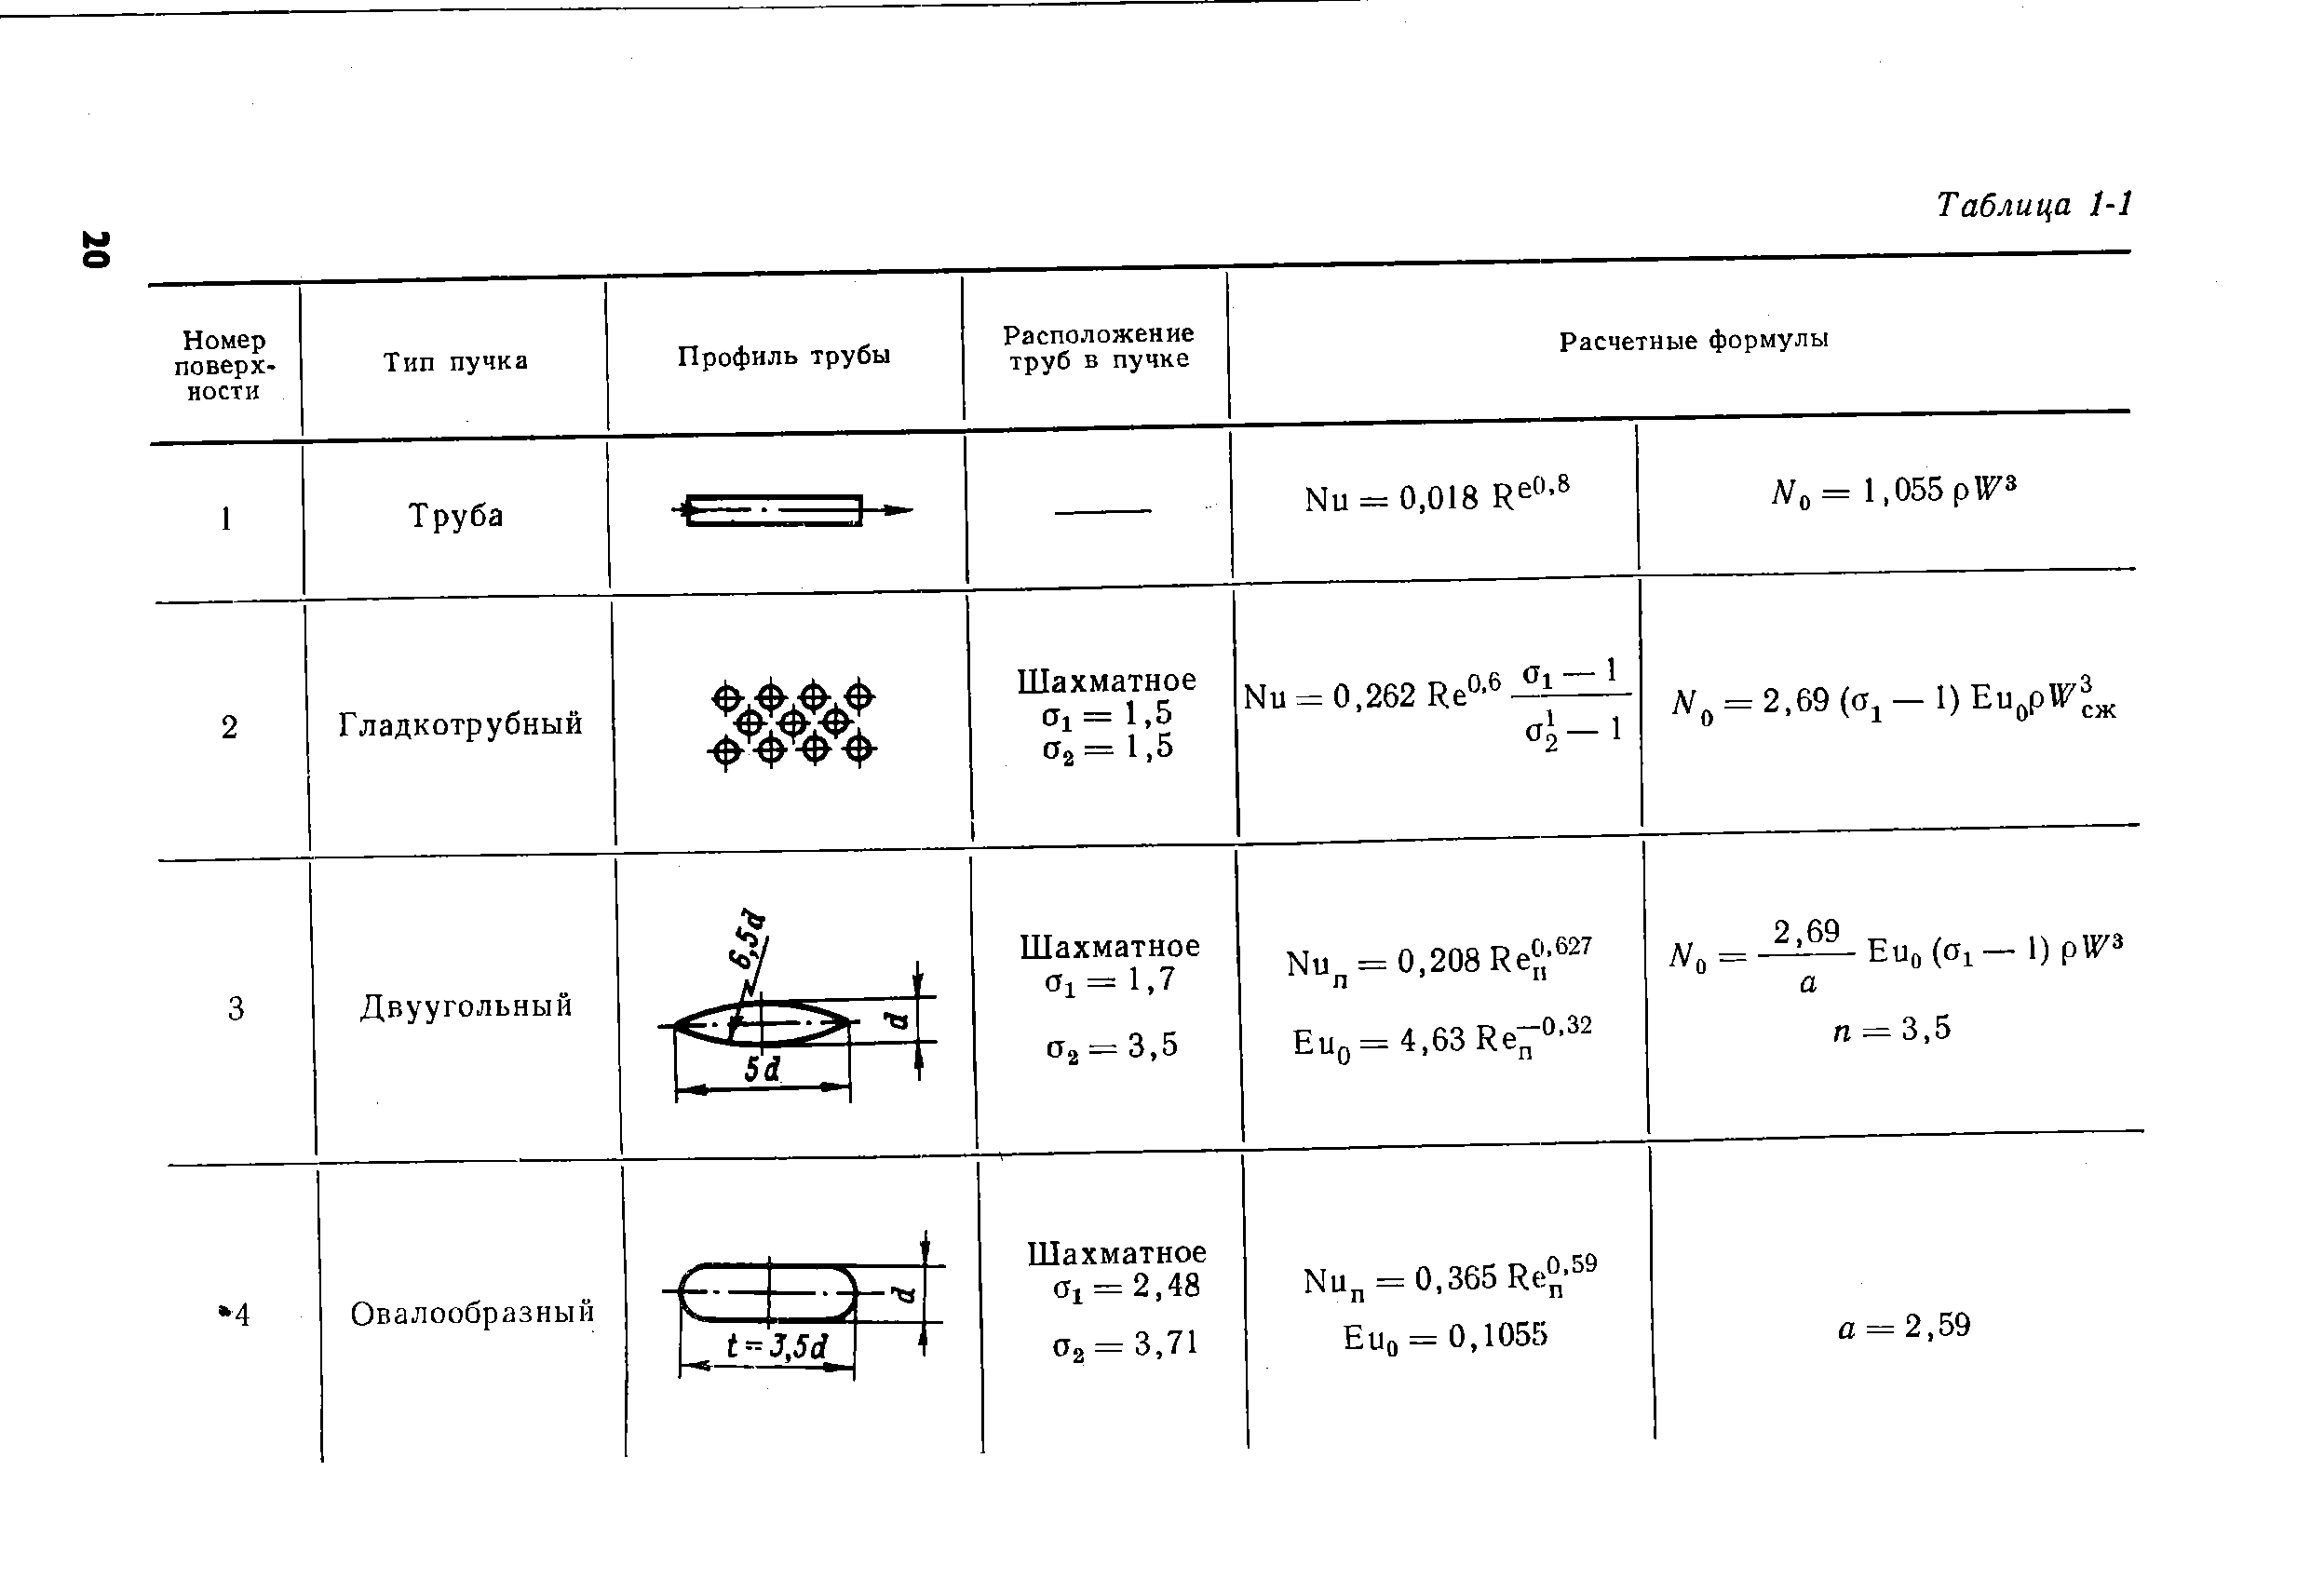

# Import modules




In [1]:
import numpy as np

# Correlations

In [45]:
class Correlation:
  def __init__(self):
    pass

  def __call__(self):
    pass

## NuRe

https://en.wikipedia.org/wiki/Nusselt_number

https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Table_of_Approximations

In [46]:
class GnielinskiPetukhov(Correlation):
  """Gnielinski correlation with Petukhov approximation of Darcy friction factor

  Nu = f(Re, Pr, f) = (f/8)*(re - 1000)*pr/(1 + 12.7*(f/8)**0.5*(pr**0.667 - 1))
  f = (0.79*ln(re) - 1.65)**-2 (Darcy friction factor, Petukhov)

  https://en.wikipedia.org/wiki/Nusselt_number#Gnielinski_correlation 
  """
  def __init__(self, re_lim=(3000, 5e6), pr_lim=(0.5, 2000)):
    super().__init__()
    self.re_lim, self.pr_lim = re_lim, pr_lim

  def __call__(self, re=None, pr=None, **kwargs):
    for v, lim in [(re, self.re_lim), (pr, self.pr_lim)]:
      if v is None or not lim[0] <= v <= lim[1]:
        return None
    f = (0.79*np.log(re) - 1.65)**-2
    return (f/8)*(re - 1000)*pr/(1 + 12.7*(f/8)**0.5*(pr**2/3 - 1))

class DittusBoelter(Correlation):
  """Dittus-Boelter correlation 

  Nu = f(Re, Pr) = c * Re**n * Pr**m

  https://en.wikipedia.org/wiki/Nusselt_number#Dittus-Boelter_equation  
  """
  def __init__(self, c=0.023, n=0.8, m=0.35,
               re_lim=(10000, np.inf), pr_lim=(0.6, 160), 
               ld_lim=(10, np.inf)):
    super().__init__()
    self.c, self.n, self.m = c, n, m
    self.re_lim, self.pr_lim, self.ld_lim = re_lim, pr_lim, ld_lim

  def __call__(self, re=None, pr=None, l=10, d=1, **kwargs):
    for v, lim in [(re, self.re_lim), (pr, self.pr_lim), (l/d, self.ld_lim)]:
      if v is None or not lim[0] <= v <= lim[1]:
        return None
    return self.c*re**self.n*pr**self.m

class SiederTate(Correlation):
  """Sieder-Tate correlation 

  Nu = f(Re, Pr, μ, μs) = c * Re**n * Pr**m * (μ/μs)**p

  https://en.wikipedia.org/wiki/Nusselt_number#Sieder-Tate_correlation
  """
  def __init__(self, c=0.027, n=0.8, m=1/3, p=0.14, 
               re_lim=(10000, np.inf), pr_lim=(0.7, 16700), 
               mu_lim=(0, np.inf), ld_lim=(10, np.inf)):
    super().__init__()
    self.c, self.n, self.m, self.p = c, n, m, p
    self.re_lim, self.pr_lim = re_lim, pr_lim
    self.mu_lim, self.ld_lim = mu_lim, ld_lim

  def __call__(self, re=None, pr=None, mu=None, mu_s=None, l=10, d=1, **kwargs):
    mu_s = mu if mu_s is None else mu_s
    for v, lim in [(re, self.re_lim), (pr, self.pr_lim), (mu, self.mu_lim), 
                   (mu_s, self.mu_lim), (l/d, self.ld_lim)]:
      if v is None or not lim[0] <= v <= lim[1]:
        return None
    return self.c*re**self.n*pr**self.m*(mu/mu_s)**self.p

class LaminarUniformTemperature(Correlation):
  """Convection with uniform temperature for circular tubes
  DeWitt, David P. Fundamentals of heat and mass transfer. John Wiley & Sons, 2002.
  
  https://en.wikipedia.org/wiki/Nusselt_number#Convection_with_uniform_temperature_for_circular_tubes
  """
  def __init__(self, re_lim=(0, 2300)):
    super().__init__()
    self.re_lim = re_lim

  def __call__(self, re=None, **kwargs):
    for v, lim in [(re, self.re_lim)]:
        if v is None or not lim[0] <= v <= lim[1]:
          return None
    return 3.66

class LaminarUniformHeatFlux(Correlation):
  """Convection with uniform heat flux for circular tubes
  DeWitt, David P. Fundamentals of heat and mass transfer. John Wiley & Sons, 2002.

  https://en.wikipedia.org/wiki/Nusselt_number#Convection_with_uniform_heat_flux_for_circular_tubes
  """
  def __init__(self, re_lim=(0, 2300)):
    super().__init__()    
    self.re_lim = re_lim

  def __call__(self, re=None, **kwargs):
    for v, lim in [(re, self.re_lim)]:
        if v is None or not lim[0] <= v <= lim[1]:
          return None
    return 4.36

## EuRe

https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation

https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Table_of_Approximations



In [47]:
class DarcyWeisbachBlasius(Correlation):
  """Darcy–Weisbach with Blasius approximation of Darcy friction factor
  """
  def __init__(self, c=0.3164, n=-0.25, re_lim=(0, 100000), 
               ld_lim=(-np.inf, np.inf)):
    super().__init__()
    self.c, self.n = c, n
    self.re_lim, self.ld_lim = re_lim, ld_lim
  
  def __call__(self, re=None, l=10, d=1, **kwargs):
    for value, lim in [(re, self.re_lim), (l/d, self.ld_lim)]:
      if value is None or not lim[0] <= value <= lim[1]:
        return None
    # Darcy friction factor
    if 0 < re < 2300:  # Laminar
      f = 64/re
    elif 2300 <= re <= 2900:  # Transition (Blasius)
      f = self.c*re**self.n  
    elif 2900 < re < 100000:   # Turbulent (Blasius)
      f = self.c*re**self.n
    else:
      return None
    eu = 0.5*f*l/d
    return eu

## Other

In [48]:
class MeanCorrelation(Correlation):
  """Mean of several correlations
  """
  def __init__(self, cs):
    super().__init__()
    self.cs = cs

  def __call__(self, **kwargs):
    vs = []
    for c in self.cs:
        v = c(**kwargs)
        vs.append(v)
    vs = [x for x in vs if x is not None]
    if len(vs) == 0:
      return None
    else:
      return np.mean(vs)

class MedianCorrelation(Correlation):
  """Mean of several correlations
  """
  def __init__(self, cs):
    super().__init__()
    self.cs = cs

  def __call__(self, **kwargs):
    vs = []
    for c in self.cs:
        v = c(**kwargs)
        vs.append(v)
    vs = [x for x in vs if x is not None]
    if len(vs) == 0:
      return None
    else:
      return np.median(vs)

# Test
m = MeanCorrelation(cs=[GnielinskiPetukhov(), DittusBoelter(), SiederTate(), 
                        LaminarUniformTemperature(), LaminarUniformHeatFlux()])
for re in range(2000, 30000, 1000):
  for pr in range(0, 100, 100):
    m(re=re, pr=pr, mu=1)

# Test
m = MedianCorrelation(cs=[DarcyWeisbachBlasius()])
for re in range(2000, 30000, 1000):
    m(re=re)

# Surfaces

In [49]:
class Surface:
  def __init__(self, r=0):
    self.r = r  # roughness

class PlateFlat(Surface):
  def __init__(self, h, w, t, n_h, n_c, l_h, l_c, r=0):
    super().__init__(r=r)
    self.h, self.w, self.t = h, w, t  # height, width, thickness
    self.n_h, self.n_c = n_h, n_c  # number of hot/cold channels
    self.l_h, self.l_c = l_h, l_c  # hot/cold gap
    self.he, self.we, self.te = self.h, self.w, self.t  # equivalent sizes
    self.a = self.h*self.w  # heat transfer area 
    self.v = self.h*self.w*self.t  # volume
    self.a_h = self.l_h*self.h  # area of hot channel 
    self.p_h = 2*self.l_h + 2*self.h  # perimeter of hot channel 
    self.de_h = 4*self.a_h/self.p_h  # equivalent diameter of hot channel
    self.a_c = self.l_c*self.h  # area of cold channel 
    self.p_c = 2*self.l_c + 2*self.h  # perimeter of cold channel 
    self.de_c = 4*self.a_c/self.p_c  # equivalent diameter of cold channel
    self.n = self.n_h + self.n_c - 1  # number of plates
    self.l = self.n_h*self.l_h + self.n_c*self.l_c + self.n*self.t  # length

class PlateA(Surface):
  def __init__(self, h, w, t, n_h, n_c, s_h, s_w, s_r, delta, r=0):
    super().__init__(r=r)
    self.h, self.w, self.t = h, w, t  # height, width, thickness
    self.n_h, self.n_c = n_h, n_c  # number of hot/cold channels
    self.s_h, self.s_w = s_h, s_w  # step by height, step by width
    self.s_r = s_r  # radius
    self.delta = delta  # gap by width
    self.k = self.s_h/(2*self.s_r)
    self.psi = 2.3836 - 1.0743*self.k + 0.28485*self.k**2 - 0.02515*self.k**3
    self.he, self.we, self.te = self.h, self.w, self.t  # equivalent sizes
    self.n_i = self.h/self.s_h  # number of hot subchannels
    # area of hot/cold subchannel
    self.a_i = 0.5*self.s_h*(2*self.s_r + 2*self.t) - self.s_h*self.psi*self.t
    self.a_h = self.n_i*self.a_i  # area of hot channel
    self.p_h = 2*self.n_i*self.s_h*self.psi  # perimeter of hot channel
    self.de_h = 4*self.a_h/self.p_h  # equivalent diameter of hot channel
    self.a_c = self.n_i*self.a_i  # area of cold channel
    self.p_c = 2*self.n_i*self.s_h*self.psi  # perimeter of cold channel
    self.de_c = 4*self.a_c/self.p_c  # equivalent diameter of cold channel
    self.k2 = self.psi + self.delta/self.s_w*(1 - self.psi)
    self.a = self.h*self.w*self.k2  # heat transfer area
    self.v = self.a*self.t  # volume
    self.n = self.n_h + self.n_c - 1  # number of plates
    # length
    self.l = 0.5*self.n_h*2*self.s_r + 0.5*self.n_c*2*self.s_r + 2*self.n*self.t  

class PlateB(Surface):
  def __init__(self, h, w, t, n_h, n_c, l_h, l_c, s_h, s_w, s_r, delta, r=0):
    super().__init__(r=r)
    self.h, self.w, self.t = h, w, t  # height, width, thickness
    self.n_h, self.n_c = n_h, n_c  # number of hot/cold channels
    self.l_h, self.l_c = l_h, l_c  # hot/cold gap
    self.s_h, self.s_w = s_h, s_w  # step by height, step by width
    self.s_r = s_r  # radius
    self.delta = delta  # gap by width
    self.k = self.s_h/(2*self.s_r)
    self.psi = 2.3836 - 1.0743*self.k + 0.28485*self.k**2 - 0.02515*self.k**3
    self.he, self.we, self.te = self.h, self.w, self.t  # equivalent sizes
    self.n_i = self.h/self.s_h  # number of hot subchannels
    # area of hot/cold subchannel
    # self.a_i = 0.5*self.s_h*(2*self.s_r + 2*self.t) - self.s_h*self.psi*self.t
    self.a_h = self.l_h*self.h*(1 - self.delta/self.s_w)  # area of hot channel    
    self.p_h = 2*self.n_i*self.s_h*self.psi  # perimeter of hot channel
    self.de_h = 4*self.a_h/self.p_h  # equivalent diameter of hot channel
    self.a_c = self.l_c*self.h*(1 - self.delta/self.s_w)  # area of cold channel
    self.p_c = 2*self.n_i*self.s_h*self.psi  # perimeter of cold channel
    self.de_c = 4*self.a_c/self.p_c  # equivalent diameter of cold channel
    self.k2 = self.psi + self.delta/self.s_w*(1 - self.psi)
    self.a = self.h*self.w*self.k2  # heat transfer area
    self.v = self.a*self.t  # volume
    self.n = self.n_h + self.n_c - 1  # number of plates
    self.l = self.n_h*2*self.s_r + self.n_c*2*self.s_r + self.n*self.t  # length

class PlateC(Surface):
  def __init__(self, h, w, t, n_h, n_c, s_h, s_w, s_r, r=0):
    super().__init__(r=r)
    self.h, self.w, self.t = h, w, t  # height, width, thickness
    self.n_h, self.n_c = n_h, n_c  # number of hot/cold channels
    self.s_h, self.s_w = s_h, s_w  # step by height, step by width
    self.s_r = s_r  # radius
    self.k = self.s_h/(2*self.s_r)
    self.psi = 2.3836 - 1.0743*self.k + 0.28485*self.k**2 - 0.02515*self.k**3
    self.he, self.we, self.te = self.h, self.w, self.t  # equivalent sizes
    self.n_i = self.h/self.s_h  # number of hot subchannels
    # area of hot/cold subchannel
    self.a_i = 0.5*self.s_h*(2*self.s_r + 2*self.t) - self.s_h*self.psi*self.t
    self.a_h = self.n_i*self.a_i  # area of hot channel
    self.p_h = 2*self.n_i*self.s_h*self.psi  # perimeter of hot channel
    self.de_h = 4*self.a_h/self.p_h  # equivalent diameter of hot channel
    self.a_c = self.n_i*self.a_i  # area of cold channel
    self.p_c = 2*self.n_i*self.s_h*self.psi  # perimeter of cold channel
    self.de_c = 4*self.a_c/self.p_c  # equivalent diameter of cold channel
    self.a = self.h*self.psi*self.w*self.psi  # heat transfer area
    self.v = self.a*self.t  # volume
    self.n = self.n_h + self.n_c - 1  # number of plates
    # length
    self.l = 0.5*self.n_h*2*self.s_r + 0.5*self.n_c*2*self.s_r + 2*self.n*self.t

class PlateD(Surface):
  def __init__(self, h, w, t, n_h, n_c, l_h, l_c, s_h, s_w, s_r, s_d, r=0):
    super().__init__(r=r)
    self.h, self.w, self.t = h, w, t  # height, width, thickness
    self.n_h, self.n_c = n_h, n_c  # number of hot/cold channels
    self.l_h, self.l_c = l_h, l_c  # hot/cold gap
    self.s_h, self.s_w = s_h, s_w  # step by height, step by width
    self.s_r = s_r  # radius
    self.s_d = s_d  # depth
    # https://en.wikipedia.org/wiki/Spherical_cap
    self.a_h = self.l_h*self.h  # area of hot channel
    self.p_h = 2*self.l_h + 2*self.h   # perimeter of hot channel
    self.de_h = 4*self.a_h/self.p_h  # equivalent diameter of hot channel
    self.a_c = self.l_c*self.h  # area of cold channel
    self.p_c = 2*self.l_c + 2*self.h  # perimeter of cold channel
    self.de_c = 4*self.a_c/self.p_c  # equivalent diameter of cold channel
    a0_i = np.pi*self.s_r**2
    a1_i = np.pi*(self.s_d**2 + self.s_r**2)
    da_i = a1_i - a0_i
    # da_i = np.pi*self.h**2  # pi*(h**2 + r**2) - pi*r**2 = pi*h**2
    dv_i = np.pi*self.s_d*(3*self.s_r**2 + self.s_d**2)/6
    n_i = self.h/self.s_h - 1  # holes by height 
    n_j = self.w/self.s_w - 1  # holes by width
    n_ij = n_i*n_j - 0.5*n_j # holes by one side (chess)
    # n_ij = n_i*n_j  # holes by one side (tile)
    da = da_i*n_ij  # delta area
    dv = 2*dv_i*n_ij  # delta volume (two sides)
    self.a = self.h*self.w + da
    self.v = self.h*self.w*self.t - dv
    self.te = self.v/(self.h*self.w)  # equivalent thickness
    self.we, self.he = self.w, self.h  # equivalent sizes
    self.n = self.n_h + self.n_c - 1  # number of plates
    self.l = self.n_h*self.l_h + self.n_c*self.l_c + self.n*self.t  # length
  

h, w, t, n_h, n_c = 1, 1, 1e-3, 10, 10
flat = PlateFlat(h=h, w=w, t=t, n_h=n_h, n_c=n_c, 
                 l_h=10e-3, l_c=10e-3)
print(flat.__dict__)
a = PlateA(h=h, w=w, t=t, n_h=n_h, n_c=n_c, 
           s_h=5e-3, s_w=5e-3, s_r=5e-3, delta=5e-3)
print(a.__dict__)
b = PlateB(h=h, w=w, t=t, n_h=n_h, n_c=n_c,  
           l_h=10e-3, l_c=10e-3,
           s_h=5e-3, s_w=5e-3, s_r=5e-3, delta=1e-3)
print(b.__dict__)
c = PlateC(h=h, w=w, t=t,n_h=n_h, n_c=n_c, 
           s_h=5e-3, s_w=5e-3, s_r=5e-3)
print(c.__dict__)
d = PlateD(h=h, w=w, t=t, n_h=n_h, n_c=n_c, 
           l_h=10e-3, l_c=10e-3,
           s_h=5e-3, s_w=5e-3, s_r=5e-3, s_d=.2e-3)
print(d.__dict__)

{'r': 0, 'h': 1, 'w': 1, 't': 0.001, 'n_h': 10, 'n_c': 10, 'l_h': 0.01, 'l_c': 0.01, 'he': 1, 'we': 1, 'te': 0.001, 'a': 1, 'v': 0.001, 'a_h': 0.01, 'p_h': 2.02, 'de_h': 0.019801980198019802, 'a_c': 0.01, 'p_c': 2.02, 'de_c': 0.019801980198019802, 'n': 19, 'l': 0.219}
{'r': 0, 'h': 1, 'w': 1, 't': 0.001, 'n_h': 10, 'n_c': 10, 's_h': 0.005, 's_w': 0.005, 's_r': 0.005, 'delta': 0.005, 'k': 0.5, 'psi': 1.9145187499999998, 'he': 1, 'we': 1, 'te': 0.001, 'n_i': 200.0, 'a_i': 2.0427406250000002e-05, 'a_h': 0.00408548125, 'p_h': 3.8290374999999996, 'de_h': 0.0042678936939113295, 'a_c': 0.00408548125, 'p_c': 3.8290374999999996, 'de_c': 0.0042678936939113295, 'k2': 1.0, 'a': 1.0, 'v': 0.001, 'n': 19, 'l': 0.138}
{'r': 0, 'h': 1, 'w': 1, 't': 0.001, 'n_h': 10, 'n_c': 10, 'l_h': 0.01, 'l_c': 0.01, 's_h': 0.005, 's_w': 0.005, 's_r': 0.005, 'delta': 0.001, 'k': 0.5, 'psi': 1.9145187499999998, 'he': 1, 'we': 1, 'te': 0.001, 'n_i': 200.0, 'a_h': 0.008, 'p_h': 3.8290374999999996, 'de_h': 0.00835719159

# Heat Exchanger

In [61]:
class PHE():
  """General plate heat exchanger

  Attributes:
    h (float): Height ~ height the plates, m
    l (float): Length ~ number of channels * (width of channels + thickness of plates), m
    w (float): Width ~ width of plates, m
    t_h1 (float): Inlet temperature of hot fluid, K
    t_h2 (float): Outlet temperature of hot fluid, K
    t_c1 (float): Inlet temperature of cold fluid, K
    t_c2 (float): Outlet temperature of hot fluid, K
    p_h1 (float): Inlet pressure of hot fluid, Pa
    p_h2 (float): Outlet pressure of hot fluid, Pa
    p_c1 (float): Inlet pressure of cold fluid, Pa
    p_c2 (float): Outlet pressure of hot fluid, Pa
    g_h (float): Mass flow rate of hot fluid, kg/s
    g_c (float): Mass flow rate of cold fluid, kg/s
    v_h (float): Velocity of hot fluid, m/s
    v_c (float): Velocity of cold fluid, m/s
    mat_h (str): Material of hot fluid
    mat_c (str): Material of cold fluid
    mat_p (str): Material of plates
    plate (Surface): Surface object (see above)
    nure_h (Correlation): Nu(Re, ...) correlation for hot fluid
    nure_c (Correlation): Nu(Re, ...) correlation for cold fluid
    eure_h (Correlation): Eu(Re, ...) correlation for hot fluid
    eure_c (Correlation): Eu(Re, ...) correlation for cold fluid
    t_h (float): Mean temperature of hot fluid, K
    t_c (float): Mean temperature of cold fluid, K
    p_h (float): Mean pressure of hot fluid, Pa
    p_c (float): Mean pressure of cold fluid, Pa
    t_p (float): Mean temperature of plates, K
    rho_h (float): Mean density of hot fluid, kg/m3
    rho_c (float): Mean density of cold fluid, kg/m3
    rho_p (float): Mean density of plates, kg/m3
    cp_h (float): Mean specific heat of hot fluid, J/(kg*K)
    cp_c (float): Mean specific heat of cold fluid, J/(kg*K)
    k_h (float): Mean thermal conductivity of hot fluid, W/(m*K)
    k_c (float): Mean thermal conductivity of cold fluid, W/(m*K)
    k_p (float): Mean thermal conductivity of plates, W/(m*K)
    mu_h (float): Mean dynamic viscosity of hot fluid, Pa*s
    mu_c (float): Mean dynamic viscosity of cold fluid, Pa*s
    nu_h (float): Mean kinematic viscosity of hot fluid, m^2/s
    nu_c (float): Mean kinematic viscosity of cold fluid, m^2/s
    aplha_h (float): Mean thermal diffusivity of hot fluid, m2/s
    aplha_c (float): Mean thermal diffusivity of cold fluid, m2/s
    a_h (float): Area of hot heat transfer surfaces
    a_c (float): Area of cold heat transfer surfaces
    de_h (float): Equivalent diameter of hot fluid channels
    de_c (float): Equivalent diameter of hot cold channels
    we (float): Equivalent length of channels ~ width of plates
    te (float): Equivalent thickness of plates ~ thickness of plates
    wede_h (float): Equivalent length by equivalent diameter of hot fluid channels
    wede_c (float): Equivalent length by equivalent diameter of cold fluid channels
    p (float): Power of heat exchanger, W
    re_h (float): Reynolds number of hot fluid
    re_c (float): Reynolds number of cold fluid
    pr_h (float): Prandtl number of hot fluid
    pr_c (float): Prandtl number of cold fluid
    nus_h (float): Nusselt number of hot fluid
    nus_c (float): Nusselt number of cold fluid
    eu_h (float): Euler number of hot fluid
    eu_c (float): Euler number of cold fluid
    dt1 (float): Temperature difference between hot outlet and cold inlet, K
    dt2 (float): Temperature difference between hot inlet and cold outlet, K
    dt_log (float): Logarithmic mean temperature difference, K
    dt (float): Mean temperature difference, K
    htc_h (float): Heat transfer coefficient of hot fluid, W/(m2*K)
    htc_c (float): Heat transfer coefficient of cold fluid, W/(m2*K)
    htc (float): Heat transfer coefficient of heat exchanger, W/(m2*K)
    area (float): Area of heat transfer surfaces, m2
    volume (float): Volume of heat exchanger, m3
    beta (float): Area by volume of heat exchanger, m2/m3
    volume_p (float): Volume of plates, m3
    mass_p (float): Mass of plates, kg
    mass (float): Mass of heat exchanger ~ mass of plates, kg
    dp_h (float): Pressure drop of hot fluid, Pa
    dp_c (float): Pressure drop of cold fluid, Pa
    dp (float): Pressure drop total, Pa
    rp_h (float): Relative pressure drop of hot fluid
    rp_c (float): Relative pressure drop of hot fluid
    rp (float): Relative pressure drop total
    pc_h (float): Power consumption of hot fluid, W
    pc_c (float): Power consumption of cold fluid, W
    pc (float): Power consumption total, W
    ee (float): Energy efficiency of heat exchanger (Power - PowerConsumption)/Power
  """
  def __init__(self, 
               h=1, l=1, w=1,
               t_h1=89.9 + 273.15, t_h2=54.2 + 273.15, 
               t_c1=54 + 273.15, t_c2=65.5 + 273.15, 
               p_h1=0.75e6, p_h2=0.31e6, p_c1=0.48e6, p_c2=0.34e6,
               g_h=40, g_c=25,
               v_h=1, v_c=1, 
               mat_h='water', mat_c='water', mat_p='steel',
               plate=PlateFlat(h=1, w=1, t=1e-3, n_h=1, n_c=1,
                               l_h=1e-3, l_c=1e-3), 
               nure_h=MedianCorrelation([LaminarUniformHeatFlux(),
                                         GnielinskiPetukhov(), 
                                         SiederTate()]), 
               nure_c=MedianCorrelation([LaminarUniformHeatFlux(),
                                         GnielinskiPetukhov(), 
                                         SiederTate()]), 
               eure_h=DarcyWeisbachBlasius(), 
               eure_c=DarcyWeisbachBlasius(),
               rho_h=None, cp_h=None, k_h=None, mu_h=None,
               rho_c=None, cp_c=None, k_c=None, mu_c=None,
               rho_p=None, k_p=None):
    self.h, self.l, self.w = h, l, w
    self.t_h1, self.t_h2, self.t_c1, self.t_c2 = t_h1, t_h2, t_c1, t_c2 
    self.p_h1, self.p_h2, self.p_c1, self.p_c2 = p_h1, p_h2, p_c1, p_c2
    self.g_h, self.g_c = g_h, g_c
    self.v_h, self.v_c = v_h, v_c
    self.plate = plate
    self.mat_h, self.mat_c, self.mat_p = mat_h, mat_c, mat_p
    self.nure_h, self.nure_c = nure_h, nure_c
    self.eure_h, self.eure_c = eure_h, eure_c
    # Properties
    self.t_h, self.t_c = None, None
    self.p_h, self.p_c = None, None
    self.t_p = None
    self.rho_h, self.cp_h, self.k_h = rho_h, cp_h, k_h
    self.mu_h, self.nu_h = mu_h, None
    self.rho_c, self.cp_c, self.k_c = rho_c, cp_c, k_c
    self.mu_c, self.nu_c = mu_c, None
    self.rho_p, self.k_p = rho_p, k_p
    self.alpha_h, self.alpha_c = None, None
    # Geometry
    self.a_h, self.a_c = None, None
    self.de_h, self.de_c, self.we, self.te = None, None, None, None
    self.wede_h, self.wede_c = None, None
    # Heat balance and continuity equation
    self.p = None
    # Numbers
    self.re_h, self.re_c = None, None
    self.pr_h, self.pr_c = None, None
    self.nus_h, self.nus_c = None, None
    self.eu_h, self.eu_c = None, None
    # Heat transfer
    self.dt1, self.dt2, self.dt_log, self.dt = None, None, None, None
    self.htc_h, self.htc_c, self.htc = None, None, None
    self.area = None
    # Sizes
    self.volume, self.beta = None, None
    self.volume_p, self.mass_p, self.mass = None, None, None
    # Pressure drop and energy efficiency
    self.dp_h, self.dp_c, self.dp = None, None, None
    self.rp_h, self.rp_c, self.rp = None, None, None
    self.pc_h, self.pc_c, self.pc = None, None, None
    self.ee = None
    # Calculation
    # 1. Physical properties
    self.properties()
    # 2. Geometry of channels
    self.geometry() 
    # 3. Heat balance and continuity equation
    self.heat_balance_and_continuity_equation()
    # 4. Reynolds numbers
    self.reynolds()
    # 5. Prandtl numbers
    self.prandtl()
    # 6. Nusselt numbers
    self.nusselt()
    if self.nus_h is not None and self.nus_c is not None:
      # 7. Temperature difference
      self.temperature_difference()
      # 8. Heat transfer equation
      self.heat_transfer_coefficient()
      self.heat_transfer_equation()
      # 9. Size
      # Update width of plates by new area of heat transfer surfaces
      old_area = 2*self.plate.n*self.plate.a  # double | C | H | C | H | C | H |
      self.plate.w *= self.area/old_area
      self.geometry()  # update geometry with new plates width
      self.size()
    # 10. Euler numbers (pressure drop)
    self.euler()
    if self.eu_h is not None and self.eu_c is not None:
      self.pressure_drop()
      self.ee = (self.p - self.pc)/self.p  # Energy efficiency

  def properties(self): 
    # TODO implement rho(p,t), cp(p,t), k(p,t), mu(p,t) functions
    self.t_h = 0.5*(self.t_h1 + self.t_h2)
    self.p_h = 0.5*(self.p_h1 + self.p_h2)
    self.t_c = 0.5*(self.t_c1 + self.t_c2)
    self.p_c = 0.5*(self.p_c1 + self.p_c2)
    self.t_p = 0.5*(self.t_h + self.t_c)
    if self.mat_h == 'water':
      self.rho_h = 976.6 if self.rho_h is None else self.rho_h
      self.cp_h = 4190 if self.cp_h is None else self.cp_h
      self.k_h = 0.650 if self.k_h is None else self.k_h
      self.mu_h = 3.925e-4 if self.mu_h is None else self.mu_h
      self.nu_h = self.mu_h/self.rho_h
      self.alpha_h = self.k_h/(self.cp_h*self.rho_h)  
    else:
      raise NotImplementedError(self.mat_h)
    if self.mat_c == 'water':
      self.rho_c = 983.3 if self.rho_c is None else self.rho_c
      self.cp_c = 4183 if self.cp_c is None else self.cp_c
      self.k_c = 0.650 if self.k_c is None else self.k_c
      self.mu_c = 4.678e-4 if self.mu_c is None else self.mu_c
      self.nu_c = self.mu_c/self.rho_c
      self.alpha_c = self.k_c/(self.cp_c*self.rho_c)
    else:
      raise NotImplementedError(self.mat_c)
    if self.mat_p == 'steel':
      self.rho_p = 7800 if self.rho_p is None else self.rho_p
      self.k_p = 20 if self.k_p is None else self.k_p
    else:
      raise NotImplementedError(self.mat_p)

  def geometry(self):
    self.a_h = self.plate.a_h*self.plate.n_h
    self.a_c = self.plate.a_c*self.plate.n_c
    self.de_h, self.de_c = self.plate.de_h, self.plate.de_c
    self.we, self.te = self.plate.we, self.plate.te
    self.wede_h = self.plate.we / self.de_h
    self.wede_c = self.plate.we / self.de_c
    self.h, self.w, self.l = self.plate.h, self.plate.w, self.plate.l

  def heat_balance_and_continuity_equation(self):
    if self.g_h is None and self.g_c is not None:
      self.p = self.g_c*self.cp_c*(self.t_c2 - self.t_c1)
      self.g_h = self.p/self.cp_h/(self.t_h1 - self.t_h2)
    elif self.g_h is not None and self.g_c is None:
      self.p = self.g_h*self.cp_h*(self.t_h1 - self.t_h2)
      self.g_c = self.p/self.cp_c*(self.t_c2 - self.t_c1)
    else:
      raise NotImplementedError()
    self.v_h = self.g_h/self.rho_h/self.a_h
    self.v_c = self.g_c/self.rho_c/self.a_c

  def reynolds(self):
    self.re_h = self.v_h*self.de_h/self.nu_h
    self.re_c = self.v_c*self.de_c/self.nu_c

  def prandtl(self):
    self.pr_h = self.nu_h/self.alpha_h
    self.pr_c = self.nu_c/self.alpha_c

  def nusselt(self):
    self.nus_h = self.nure_h(re=self.re_h, 
                             pr=self.pr_h,
                             l=self.we,
                             d=self.de_h,
                             mu=self.mu_h,
                             mu_s=self.mu_h,  # TODO near surface viscosity
                             r=self.plate.r
                             )
    self.nus_c = self.nure_c(re=self.re_c, 
                             pr=self.pr_c,
                             l=self.we,
                             d=self.de_c,
                             mu=self.mu_c,
                             mu_s=self.mu_c,  # TODO near surface viscosity
                             r=self.plate.r
                             )
    
  def temperature_difference(self):
    self.dt1 = self.t_h2 - self.t_c1
    self.dt2 = self.t_h1 - self.t_c2
    if self.dt1 >= self.dt2:
      self.dt_log = (self.dt1 - self.dt2)/np.log(self.dt1/self.dt2)
    else:
      self.dt_log = (self.dt2 - self.dt1)/np.log(self.dt2/self.dt1) 
    self.dt = 0.5*(self.dt1 + self.dt2)

  def heat_transfer_coefficient(self):
    self.htc_h = self.nus_h*self.k_h/self.de_h
    self.htc_c = self.nus_c*self.k_c/self.de_c
    self.htc = 1/(1/self.htc_h + self.te/self.k_p + 1/self.htc_c)

  def heat_transfer_equation(self):
    self.area = self.p/self.htc/self.dt_log

  def size(self):
      self.volume = self.h*self.l*self.w
      self.beta = self.area/self.volume
      self.volume_p = self.plate.v*self.plate.n
      self.mass_p = self.volume_p*self.rho_p
      self.mass = self.mass_p

  def euler(self):
    self.eu_h = self.eure_h(re=self.re_h, 
                            l=self.we, 
                            d=self.de_h)
    self.eu_c = self.eure_c(re=self.re_c, 
                            l=self.we, 
                            d=self.de_c)
  def pressure_drop(self):
      self.dp_h = self.eu_h*self.rho_h*self.v_h**2
      self.dp_c = self.eu_c*self.rho_c*self.v_c**2
      self.dp = self.dp_h + self.dp_c
      self.rp_h = self.dp_h/self.p_h
      self.rp_c = self.dp_c/self.p_c
      self.rp = self.rp_h + self.rp_c
      self.pc_h = self.dp_h*self.g_h/self.rho_h
      self.pc_c = self.dp_c*self.g_c/self.rho_c
      self.pc = self.pc_h + self.pc_c

# Calculations

## Import modules (required)

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


## Import modules (optional)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

gdrive_path = '/gdrive/MyDrive/'

## Run

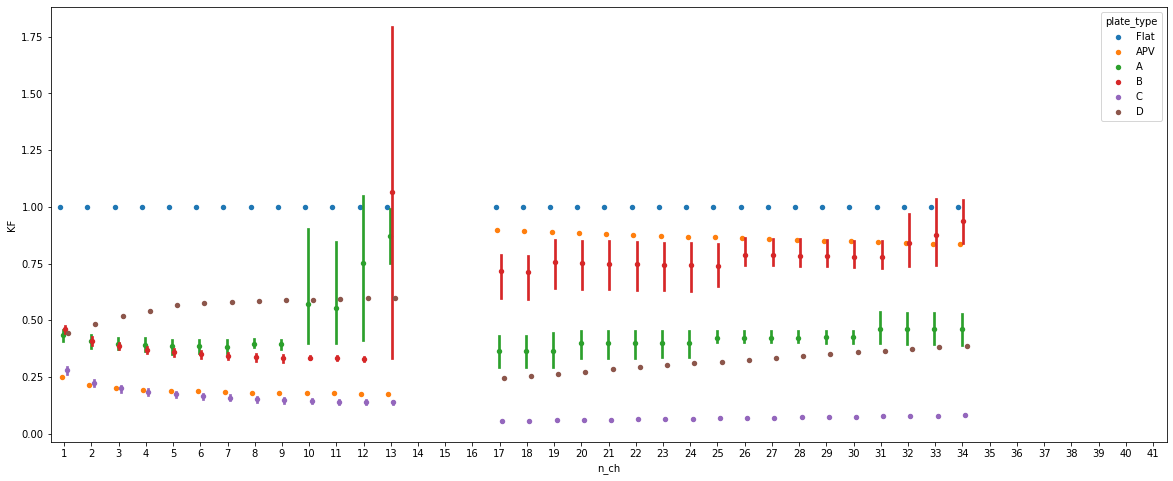

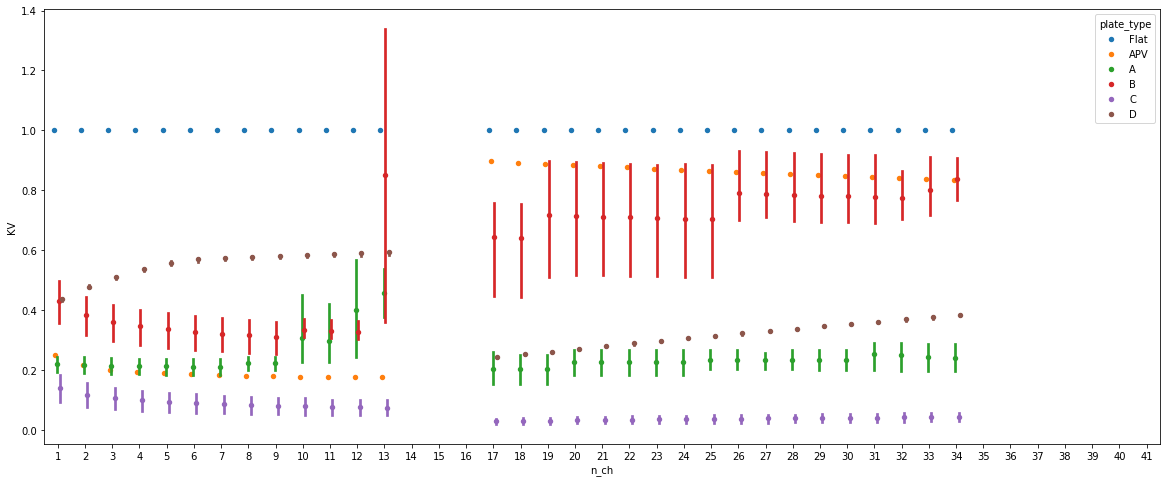

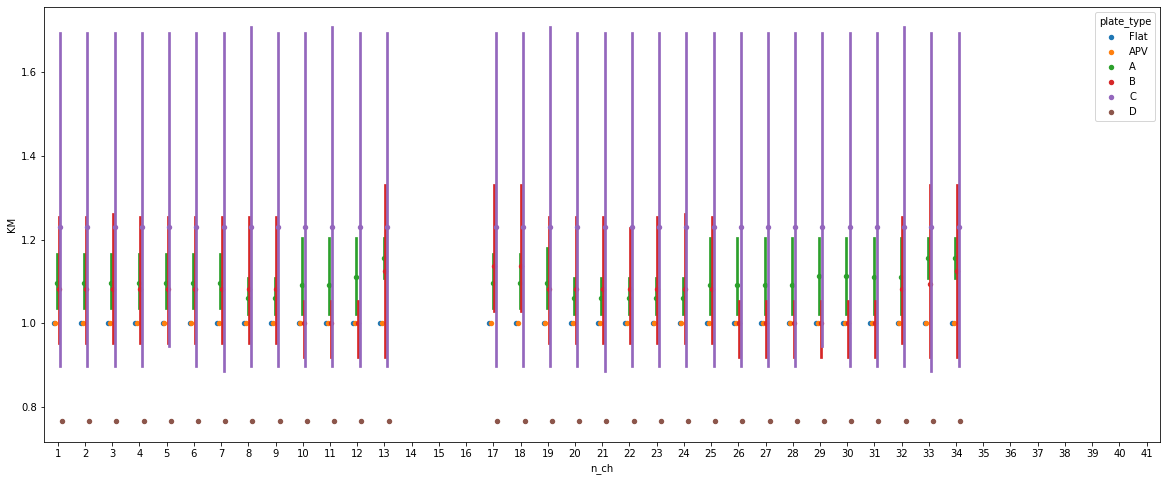

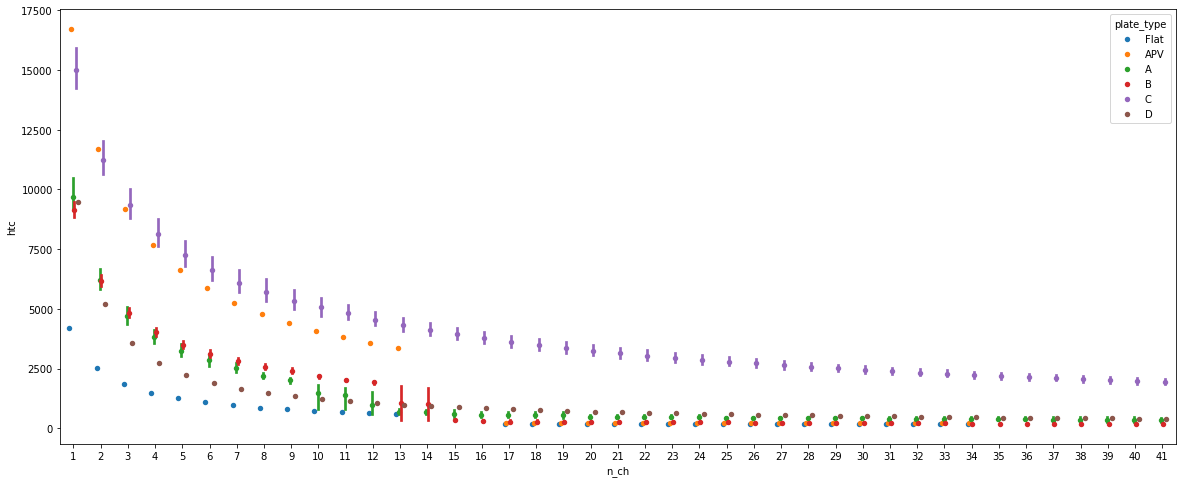

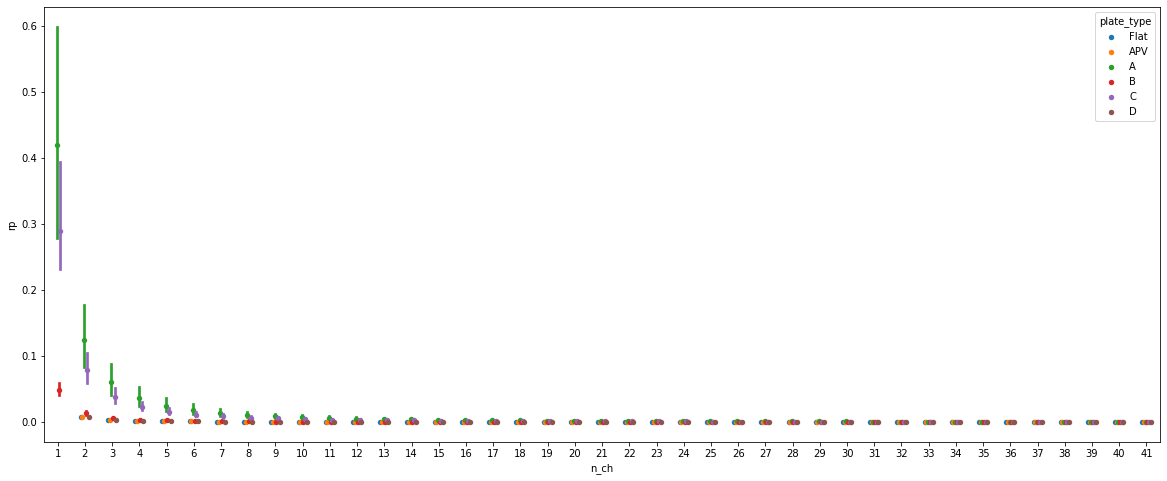

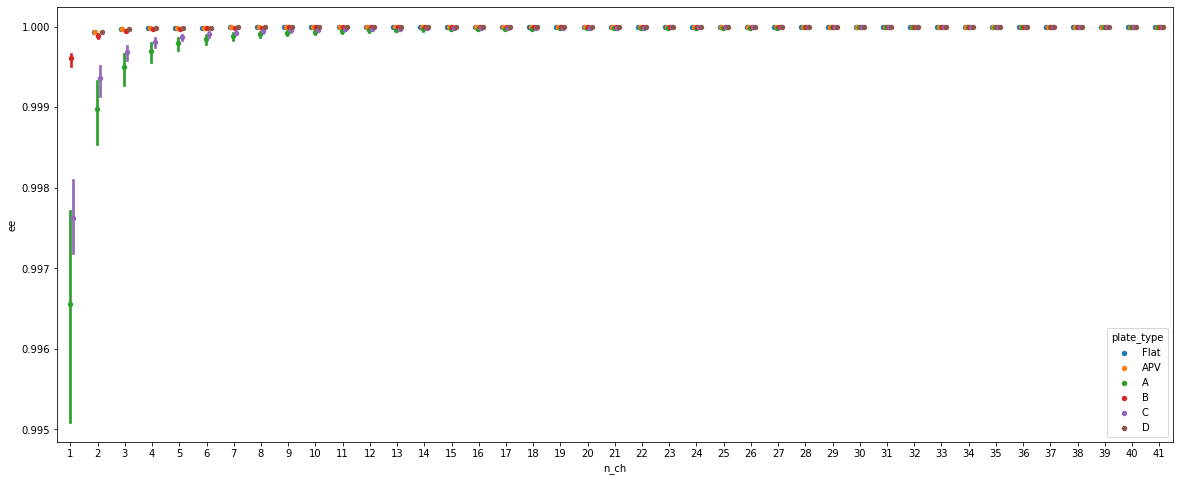

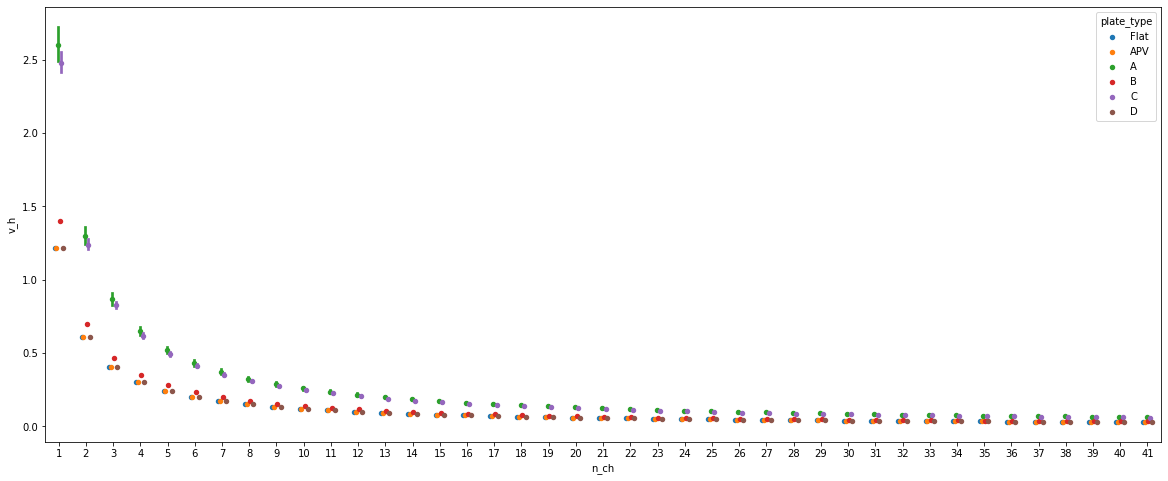

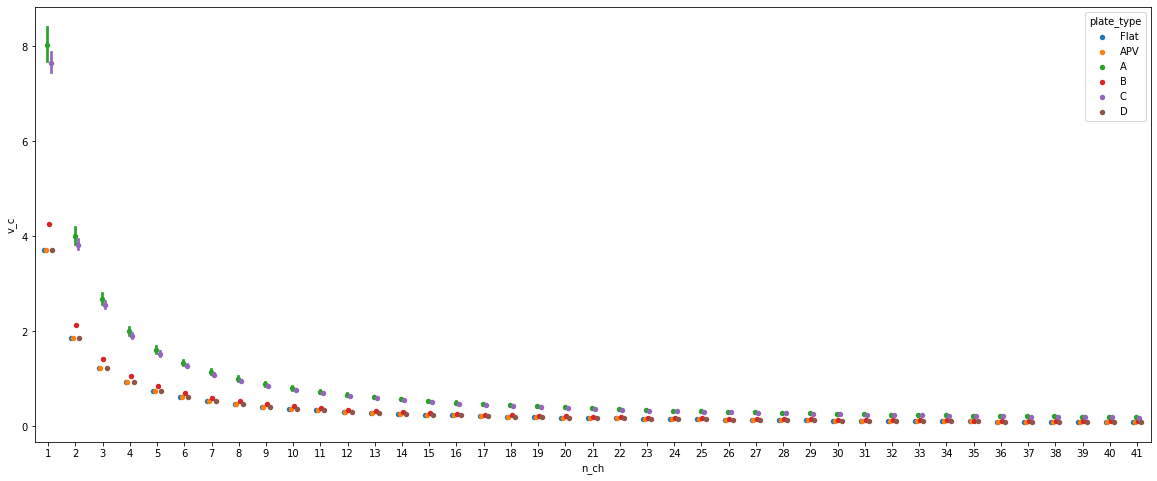

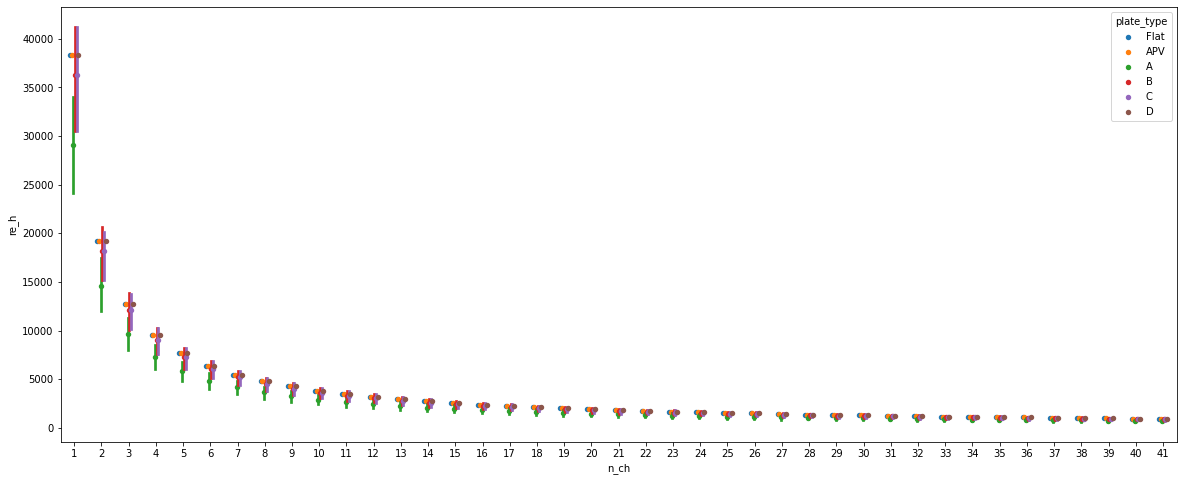

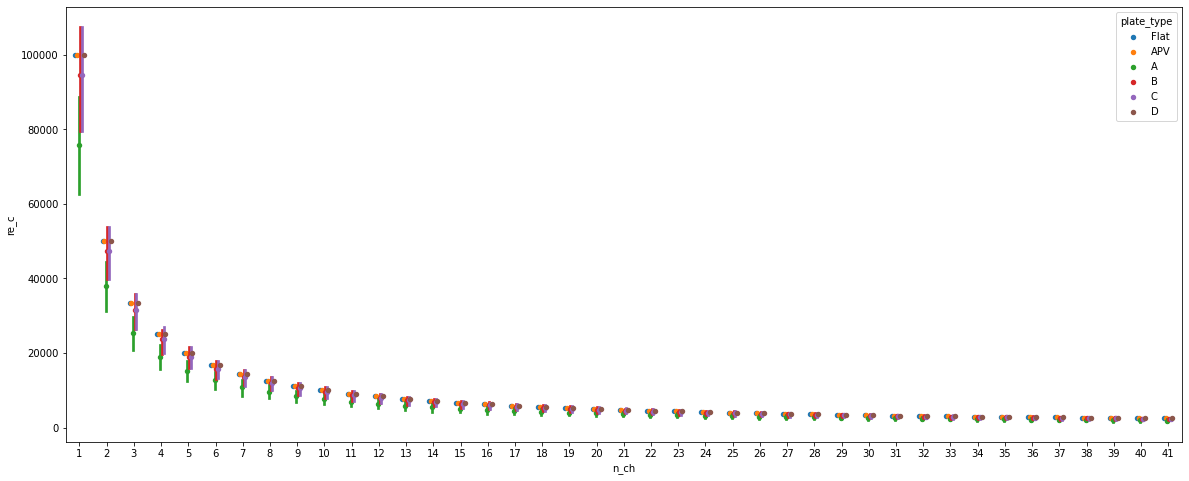

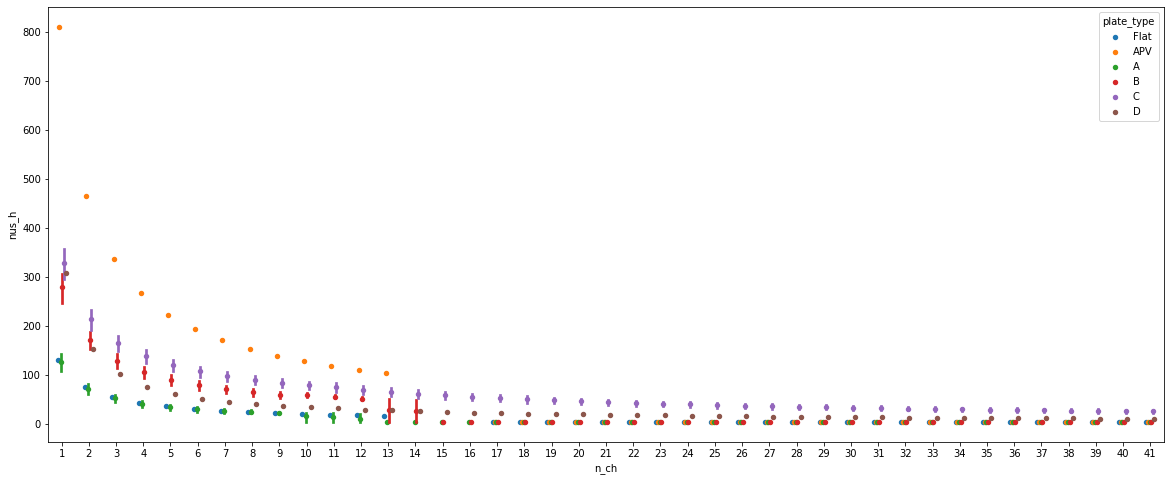

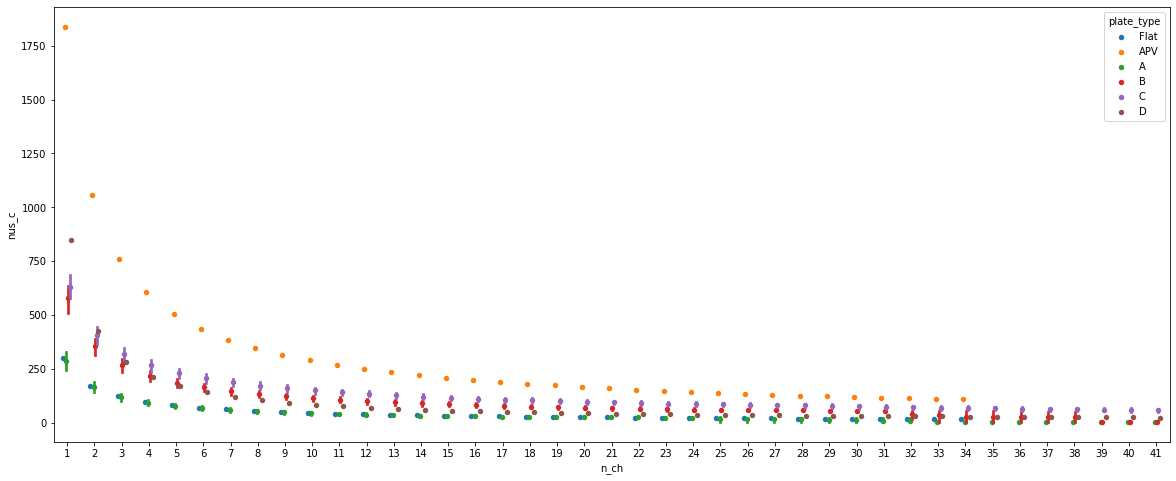

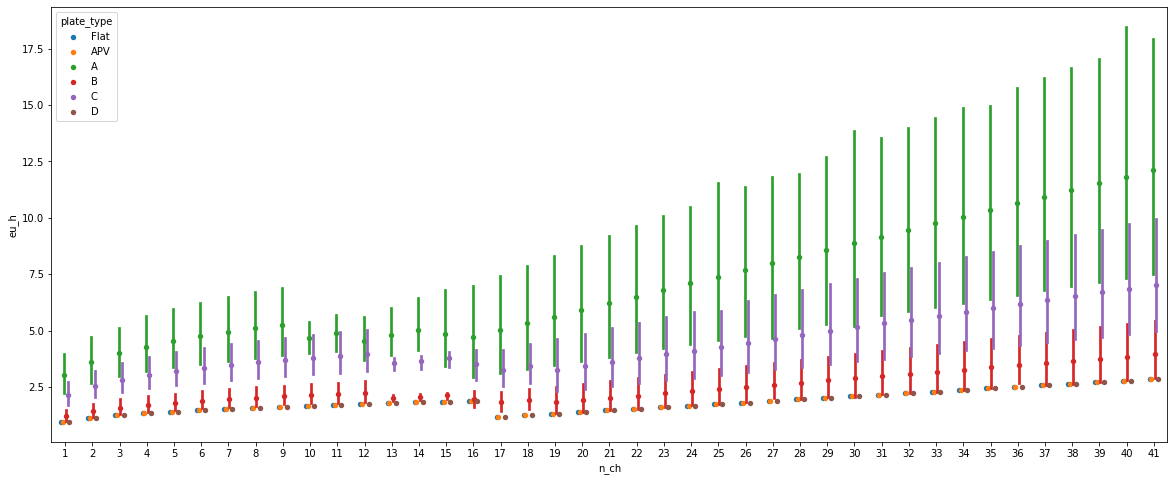

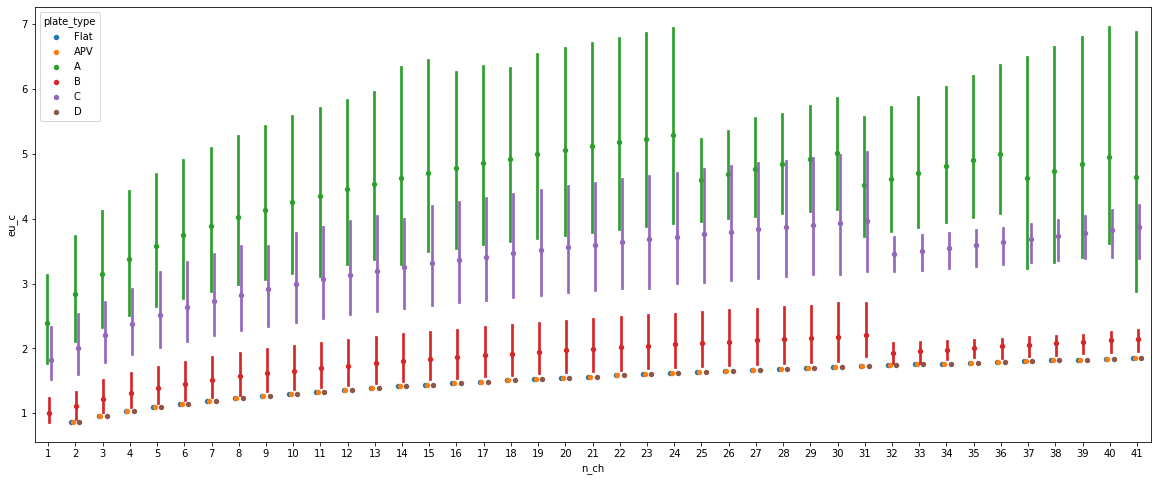

In [64]:
save, file_name = True, 'test'
plot, figsize = True, (20, 8)
results = []
n_chs = np.arange(0, 42, 1)[1:]  #  number of channels for each fluid
cfs = np.arange(0.5, 2.1, 0.5)  # step coefficent of plates profiles (waves, holes etc)
plate_types = ['Flat', 'APV', 'A', 'B', 'C', 'D']
prod = product(n_chs, cfs, plate_types)
for n_ch, cf, plate_type in prod:      
    h, w, t = 0.530, 1.056, .5e-3  # height, width and thickness of plates
    l_h, l_c = 6.4e-3, 6.5e-3  # gap between plates by heat transfer fluid
    n_h = n_c = n_ch
    g_c = 12.55  # cold flow rate
    kwargs = {
      'h': h,
      'l': None,  # depends on on number of plates
      'w': w,
      't_h1': 89.9 + 273.15, 
      't_h2': 54.2 + 273.15,
      't_c1': 54 + 273.15, 
      't_c2': 65.5 + 273.15,
      'p_h1': 0.75e6,
      'p_h2': 0.31e6,
      'p_c1': 0.48e6, 
      'p_c2': 0.34e6,
      'g_h': None,  # depends on temperatures and cold flow rate
      'g_c': g_c,  
      'v_h': None,  # depends on temperatures and flow rates
      'v_c': None  # depends on temperatures and flow rates
    }
    lam = LaminarUniformHeatFlux()
    if plate_type == 'Flat':  # Flat Plate
      plate = PlateFlat(h=h, w=w, t=t, n_h=n_h, n_c=n_c, l_h=l_h, l_c=l_c)
      turb = SiederTate(c=0.0208, n=0.8, re_lim=(2900, np.inf))
      nure_h = nure_c = MedianCorrelation([lam, turb])
    elif plate_type == 'APV':  # Heat Exchanger APV
      plate = PlateFlat(h=h, w=w, t=t, n_h=n_h, n_c=n_c, l_h=l_h, l_c=l_c)
      turb = SiederTate(c=0.132, n=0.8, m=0.3, p=0.05, re_lim=(2900, np.inf))
      nure_h = nure_c = MedianCorrelation([lam, turb])
    elif plate_type == 'A':  # honeycomb (Lavrov)
      plate = PlateA(h=h, w=w, t=t, n_h=n_h, n_c=n_c, 
                      s_h=cf*8e-3, s_w=16e-3, s_r=3.2e-3, delta=12e-3)
      # S1, S2, D0, delta, r, H1, H2 = 0.015, 0.060, 0.008, 0.001, None, None, None  # KF 0.988
      # S1, S2, D0, delta, r, H1, H2 = 0.0075, 0.015, 0.00306, 0.001,  None, None, None  # KF 0.828
      # S1, S2, D0, delta, r, H1, H2 = 0.005, 0.010, 0.00178, 0.001, None, None, None  # KF 0.746
      turb = SiederTate(c=0.025, n=0.8, re_lim=(2900, np.inf))
      nure_h = nure_c = MedianCorrelation([lam, turb])
    elif plate_type == 'B':  # waves (Lavrov)
      # S1, S2, D0, delta, r, H1, H2 = 0.0205, 0.115, 0.0096, 0.0005, 0.0028, 0.0095, 0.0095  # KF 0.767
      # S1, S2, D0, delta, r, H1, H2 = 0.0202, 0.115, 0.0075, 0.0005, 0.0030, 0.0066, 0.0066  # KF 0.758
      # S1, S2, D0, delta, r, H1, H2 = 0.0205, 0.115, 0.0084, 0.0005, 0.0053, 0.0058, 0.0058  # KF 0.825
      # S1, S2, D0, delta, r, H1, H2 = 0.0333, 0.115, 0.0093, 0.0005, 0.0261, 0.0028, 0.0028  # KF 0.873
      # delta = 15
      # s2 = 115
      # s1/d0 = 2.75 => s1 = 2.75*d0 = 2.75*2*h = 2.75*2*3.2 = 17.6
      plate = PlateB(h=h, w=w, t=t, n_h=n_h, n_c=n_c, l_h=l_h, l_c=l_c,
                     s_h=cf*17.6e-3, s_w=115e-3, s_r=3.2e-3, delta=15e-3)
      k = 2*l_h/(l_h/2 + t)  # ~
      c = 0.045*(1 + 0.9*k**0.62)
      turb = SiederTate(c=c, n=0.7, re_lim=(2900, np.inf))
      nure_h = nure_c = MedianCorrelation([lam, turb])
    elif plate_type == 'C':  # trapezoid (Lavrov)
      #  S1, S2, D0, delta, r, H1, H2 = 0.025, 0.0125, 0.0096, 0.001, None, None, None  # KF 0.570
      #  S1, S2, D0, delta, r, H1, H2 = 0.024, 0.012, 0.0088, 0.001, None, None, None  # KF 0.571
      # d1/d0 = s1/2h = 2.75
      # s1/d0 = 2.75 => s1 = 2.75*d0 = 2.75*2*h = 2.75*2*3.2 = 17.6
      plate = PlateC(h=h, w=w, t=t, n_h=n_h, n_c=n_c, 
                      s_h=cf*17.6e-3, s_w=None, s_r=3.2e-3)
      nure_1 = SiederTate(c=0.085, n=0.8, re_lim=(0, 4000))
      nure_2 = SiederTate(c=0.36, n=0.62, re_lim=(4000, np.inf))
      nure_h = nure_c = MedianCorrelation([nure_1, nure_2])
    elif plate_type == 'D':  # holes (Lavrov)
      # S1, S2, D0, delta, r, H1, H2 = 0.003, 0.003142, None, 0.0015, None, 0.004, 0.004  # KF 0.465
      # S1, S2, D0, delta, r, H1, H2 = 0.003, 0.003142, None, 0.0015, None, 0.006, 0.006  # KF 0.576
      # S1, S2, D0, delta, r, H1, H2 = 0.005, 0.00375, None, 0.001, None, 0.00708, 0.00708  # KF 0.631
      plate = PlateD(h=h, w=w, t=t, n_h=n_h, n_c=n_c, l_h=l_h, l_c=l_c,
                      s_h=cf*3e-3, s_w=cf*3e-3, s_r=cf*1.5e-3, s_d=.15e-3)
      nure_1 = SiederTate(c=0.0347, n=0.8, re_lim=(0, 7000))
      nure_2 = SiederTate(c=0.00589, n=1.0, re_lim=(7000, np.inf))
      nure_h = nure_c = MedianCorrelation([nure_1, nure_2])
    kwargs2 = {
      'plate': plate,
      'nure_h': nure_h,
      'nure_c': nure_c
    }
    kwargs.update(kwargs2)
    phe = PHE(**kwargs)
    rs = phe.__dict__
    rs['plate_type'] = plate_type
    rs['n_ch'] = n_ch
    results.append(rs)

# Results
df = pd.DataFrame(results)
df['KF'] = np.nan
df['KV'] = np.nan
df['KM'] = np.nan
df['KL'] = np.nan
df['KW'] = np.nan
df['KP'] = np.nan
df['KE'] = np.nan
df['KRe_h'] = np.nan
df['KRe_c'] = np.nan
df['KBeta'] = np.nan
for i, row in df.iterrows():
  df2 = df.loc[(df['plate_type'] == 'Flat') & (df['n_ch'] == row['n_ch'])]
  df.at[i, 'KF'] = row['area']/df2.iloc[0]['area']
  df.at[i, 'KV'] = row['volume']/df2.iloc[0]['volume']
  df.at[i, 'KM'] = row['mass']/df2.iloc[0]['mass']
  df.at[i, 'KL'] = row['l']/df2.iloc[0]['l']
  df.at[i, 'KW'] = row['w']/df2.iloc[0]['w']
  df.at[i, 'KP'] = row['rp']/df2.iloc[0]['rp']
  df.at[i, 'KE'] = row['ee']/df2.iloc[0]['ee']
  df.at[i, 'KRe_h'] = row['re_h']/df2.iloc[0]['re_h']
  df.at[i, 'KRe_c'] = row['re_c']/df2.iloc[0]['re_c']
  df.at[i, 'KBeta'] = row['beta']/df2.iloc[0]['beta']
# Save data
if save:
  df.to_excel(f'{file_name}-raw.xlsx')
  df.to_html(f'{file_name}-raw.html')
  try:
    df.to_excel(gdrive_path + f'{file_name}-raw.xlsx')
    df.to_html(gdrive_path + f'{file_name}-raw.html')
  except NameError as e:
    pass  # For gdrive saving run Calculations -> Optional cell

if plot:
  # Plot data (y by x)
  xs = ['n_ch', 
        # 'v_h', 'v_c', 're_h', 're_c']
        ]
  ys = [
        'KF', 'KV', 'KM', 
        # 'KL', 'KW', 'KP', 'KE', 'KRe_h', 'KRe_c', 'KBeta', 
        'htc', 'rp', 'ee',
        # 'area', 'de_h', 'ld_h', 'w', 'l', 
        'v_h', 'v_c',
        're_h', 're_c', 
        # 'pr_h', 'pr_c', 
        'nus_h', 'nus_c', 
        'eu_h', 'eu_c', 
        # 'g_h', 'g_c', 'a_h', 'a_c'
        ]
  for x in xs:
    for y in ys:
      fig, ax = plt.subplots(figsize=figsize)
      sns.pointplot(data=df, x=x, ax=ax, y=y, 
                    markers='.', linestyles='', dodge=0.3,
                    hue='plate_type')
      # sns.lineplot(data=df, x=x, ax=ax, y=y, 
      #              style='plate_type', 
      #              hue='plate_type')
      # if x == 'n_ch':
      #   ax.axvline(x=131, c='k')
      #   ax.axvline(x=83, c='k')
      # ax.grid()
      if save:
        plt.savefig(f'{y} by {x}.png')
        try:
          plt.savefig(gdrive_path + f'{file_name}-{y}_{x}.png')
        except NameError as e:
          pass  # For gdrive saving run Calculations -> Optional cell

# Pivot data
data = []
for t in ['Flat', 'APV', 
          'A', 'B', 'C', 'D'
          ]:
  df2 = df.loc[df['plate_type'] == t]
  for x in ['KF', 'KV', 'KM', 'KL', 'KW', 'KP', 'KE', 'KRe_h', 'KRe_c', 'KBeta', 
            'htc'
            ]:
    mn, mx = df2[x].min(), df2[x].max()
    d = {'Profile': t, 'Parameter': x, 'Range': f'{mn:.3f} - {mx:.3f}'}
    data.append(d)
df2 = pd.DataFrame(data)
df2 = df2.pivot(index="Profile", columns="Parameter", values="Range")
if save:
  df2.to_excel(f'{file_name}.xlsx')
  df2.to_html(f'{file_name}.html')
  try:
    df2.to_excel(gdrive_path + f'{file_name}.xlsx')
    df2.to_html(gdrive_path + f'{file_name}.html')
  except NameError as e:
    pass  # For gdrive saving run Calculations -> Optional cell

In [63]:
df

,h,l,w,t_h1,t_h2,t_c1,t_c2,p_h1,p_h2,p_c1,p_c2,g_h,g_c,v_h,v_c,plate,mat_h,mat_c,mat_p,nure_h,nure_c,eure_h,eure_c,t_h,t_c,p_h,p_c,t_p,rho_h,cp_h,k_h,mu_h,nu_h,rho_c,cp_c,k_c,mu_c,nu_c,rho_p,k_p,...,pr_c,nus_h,nus_c,eu_h,eu_c,dt1,dt2,dt_log,dt,htc_h,htc_c,htc,area,volume,beta,volume_p,mass_p,mass,dp_h,dp_c,dp,rp_h,rp_c,rp,pc_h,pc_c,pc,ee,plate_type,n_ch,KF,KV,KM,KL,KW,KP,KE,KRe_h,KRe_c,KBeta
0,0.53,0.0134,26.975896,363.05,327.35,327.15,338.65,750000.0,310000.0,480000.0,340000.0,4.035963,12.55,1.218357,3.704831,<__main__.PlateFlat object at 0x7f9bd713b510>,water,water,steel,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,345.2,332.9,530000.0,410000.0,339.05,976.6,4190,0.65,0.000392,4.019046e-07,983.3,4183,0.65,0.000468,4.757449e-07,7800,20,...,3.010473,131.632294,300.360809,0.943976,NaN,0.2,24.4,5.037447,12.3,6765.170343,15202.223972,4191.188838,28.594449,0.191583,149.253731,0.000280,2.182752,2.182752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flat,1,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000
1,0.53,0.0134,6.758493,363.05,327.35,327.15,338.65,750000.0,310000.0,480000.0,340000.0,4.035963,12.55,1.218357,3.704831,<__main__.PlateFlat object at 0x7f9bd713b5d0>,water,water,steel,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,345.2,332.9,530000.0,410000.0,339.05,976.6,4190,0.65,0.000392,4.019046e-07,983.3,4183,0.65,0.000468,4.757449e-07,7800,20,...,3.010473,809.906781,1837.381634,0.943976,NaN,0.2,24.4,5.037447,12.3,41624.719668,92995.777991,16728.740844,7.164002,0.047999,149.253731,0.000280,2.182752,2.182752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APV,1,0.250538,0.250538,1.000000,1.000000,0.250538,NaN,NaN,1.000000,1.000000,1.000000
2,0.53,0.0074,8.788990,363.05,327.35,327.15,338.65,750000.0,310000.0,480000.0,340000.0,4.035963,12.55,2.793442,8.627141,<__main__.PlateA object at 0x7f9bd713b6d0>,water,water,steel,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,345.2,332.9,530000.0,410000.0,339.05,976.6,4190,0.65,0.000392,4.019046e-07,983.3,4183,0.65,0.000468,4.757449e-07,7800,20,...,3.010473,99.053469,226.055602,4.498740,3.539745,0.2,24.4,5.037447,12.3,20958.626417,47830.882963,10681.473203,11.219870,0.034470,325.492696,0.000337,2.628738,2.628738,34283.645614,259054.864510,293338.510125,0.064686,0.631841,0.696527,141.682910,3306.354673,3448.037583,0.994289,A,1,0.392379,0.179924,1.204323,0.552239,0.325809,NaN,NaN,0.556914,0.557018,2.180801
3,0.53,0.0133,8.819016,363.05,327.35,327.15,338.65,750000.0,310000.0,480000.0,340000.0,4.035963,12.55,1.401111,4.260556,<__main__.PlateB object at 0x7f9bd713b7d0>,water,water,steel,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,<__main__.DarcyWeisbachBlasius object at 0x7f9...,345.2,332.9,530000.0,410000.0,339.05,976.6,4190,0.65,0.000392,4.019046e-07,983.3,4183,0.65,0.000468,4.757449e-07,7800,20,...,3.010473,234.816483,486.885188,1.598951,1.238747,0.2,24.4,5.037447,12.3,18918.363939,38623.193241,9638.566090,12.433876,0.062165,200.013319,0.000372,2.903253,2.903253,3065.467549,22110.640823,25176.108373,0.005784,0.053928,0.059712,12.668558,282.201304,294.869862,0.999512,B,1,0.434835,0.324482,1.330089,0.992537,0.326922,NaN,NaN,0.733600,0.733736,1.340089
4,0.53,0.0074,3.641264,363.05,327.35,327.15,338.65,750000.0,310000.0,480000.0,340000.0,4.035963,12.55,2.590356,7.999938,<__main__.PlateC object at 0x7f9bd713b8d0>,water,water,steel,<__main__.MedianCorrelation object at 0x7f9bd7...,<__main__.MedianCorrelation object at 0x7f9bd7

In [58]:
df2

Параметр,KBeta,KF,KL,KM,KP,KRe_c,KRe_h,KV,KW,htc
Профиль,,,,,,,,,,
A,1.694 - 2.181,0.256 - 1.048,0.552 - 0.603,1.021 - 1.204,6.268 - 27.237,0.557 - 0.933,0.557 - 0.933,0.128 - 0.567,0.070 - 7.843,242.037 - 10681.473
APV,1.000 - 1.000,0.175 - 0.896,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,0.175 - 0.896,0.175 - 1.000,214.211 - 16728.741
B,0.926 - 1.340,0.310 - 1.794,0.993 - 0.993,0.919 - 1.330,1.315 - 2.295,0.734 - 1.116,0.734 - 1.115,0.231 - 1.339,0.060 - 12.875,173.518 - 9638.566
C,1.366 - 3.447,0.049 - 0.297,0.552 - 0.603,0.823 - 1.903,6.905 - 15.112,0.734 - 1.116,0.734 - 1.115,0.015 - 0.199,0.026 - 1.255,1814.389 - 16313.733
D,1.002 - 1.031,0.245 - 0.599,1.000 - 1.000,0.763 - 0.770,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,0.237 - 0.598,0.237 - 4.259,397.296 - 9476.317
Flat,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,1.000 - 1.000,178.812 - 4191.189
